# Motivation

As with most financial markets around the globe, the Singapore Exchange (SGX) has seen a massive increase in volatility. Clearly, firms are displaying weakness across all industries (except healthcare) from a fundamental standpoint.

## News Article

Channel News Asia (CNA) published an article on 23 July 2020, [Commentary: SGX sees boom in retail investments. But can it last?](https://www.channelnewsasia.com/news/commentary/sgx-boom-in-retail-investments-ipo-covid-19-12953564). In particular, the author writes,

> "Retail investors piling into equities at this moment are not so much buying on optimism about growth as they are taking a risk on equities because safer investments are offering dismal yields amid ultra-accommodative central bank policies." - Kenneth Lim

It is easy to verify that this is the case. Every week, SGX makes public some summary statistics regarding proportion of retail vs. institutional investment. But what is perhaps the more interesting question is this: How does this affect the dynamics of the market flow? Can we quantify this change?

## Change in Proportion of Market Participants

Let us first verify the statements put forth by the news article. The aforementioned reports from SGX can be downloaded from [here](https://www.sgx.com/research-education/data-reports?reportType=203&page=1&pagesize=100). I use a combination of Selenium and BeautifulSoup to scrape the necessary information:

In [43]:
from selenium import webdriver
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import pandas as pd
import urllib
import time
import os

In [34]:
driver = webdriver.Chrome()
url = "https://www.sgx.com/research-education/data-reports?reportType=203&page=1&pagesize=100"

driver.get(url)
time.sleep(15)  # wait for the page to load
soup = BeautifulSoup(driver.page_source, 'lxml')
links, fnames = [], []
for i in content:
    if 'weekly' in i.text:
        links.append(i['href'])
        fnames.append(i.text)

# os.mkdir('sgx_reports')
save_dir = 'sgx_reports'
for i, j in zip(links, fnames):
    urllib.request.urlretrieve(i, os.path.join(save_dir, "{}.xlsx".format(j)))
    
driver.close()
driver.quit()

In [62]:
institutional_spend = []
retail_spend = []

for f in tqdm(fnames):
    if fnames[0][-3:] == '20)' or fnames[0][-3:] == '19)':
        for sheet in ['Institutional', 'Retail']:
            df = pd.read_excel(os.path.join(save_dir, f+'.xlsx'), sheet_name=sheet)
            week_of = df.iloc[1:5]['Week of'].values
            spend = df.iloc(axis=1)[0].iloc[1:5].values
            if sheet == 'Institutional':
                institutional_spend.append(pd.DataFrame({
                    'Spend ($SGD Million)': spend,
                    'Week of': week_of}).set_index('Week of'))
            else:
                retail_spend.append(pd.DataFrame({
                    'Spend ($SGD Million)': spend,
                    'Week of': week_of}).set_index('Week of'))

retail = pd.concat(retail_spend)
institutional = pd.concat(institutional_spend)
retail.to_csv('spend_summaries/retail_spend.csv')
institutional.to_csv('spend_summaries/institutional_spend.csv')

overall_spend = pd.concat([retail, institutional], axis=1)
overall_spend.columns = ['Retail Spend ($M)', 'Institutional Spend ($M)']
overall_spend.sort_index(inplace=True)
overall_spend.drop_duplicates(inplace=True)
overall_spend.to_csv('spend_summaries/overall_spend.csv')

In [65]:
overall_spend.tail(3)

,Retail Spend ($M),Institutional Spend ($M)
Week of,,
2020-09-21,419.104101,-206.177721
2020-09-28,-37.309617,-121.909348
2020-10-05,-72.251477,0.047251


Now let's plot the spending figures to visualise how they have changed over time. I have collected data from 2018-12-10 to 2020-10-05 (week of).

<AxesSubplot:xlabel='Week of'>

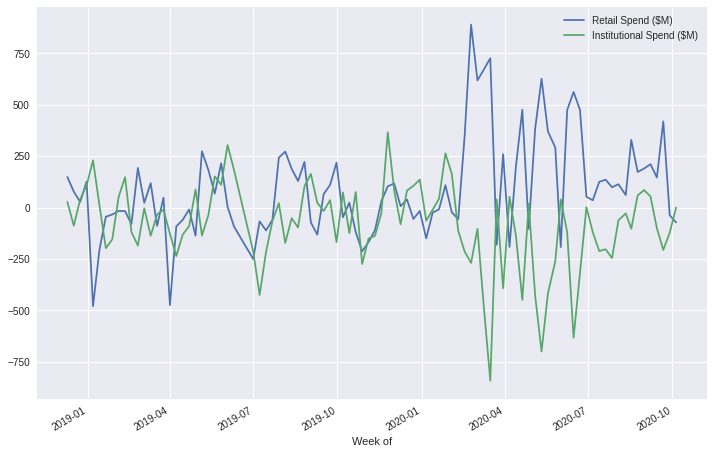

In [68]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

overall_spend.plot(figsize=(12, 8))

It is clear that, without a doubt, there has been a significant increase in the dollar volume traded per week for retail traders. However, what is interesting is that while retail traders are clearly trending long from late February, institutional investors started leaning towards the short side. To get a rough idea of how this proportion changes over time, I'll do a 23-day rolling correlation:

In [84]:
corr_coeffs = []
dates = []
for i in range(23, len(overall_spend)-23):
    corr_coeffs.append(overall_spend.iloc[i-23:i].corr()['Retail Spend ($M)'].values[-1])
    dates.append(overall_spend.index[i])
corr_trend = pd.DataFrame({'date': dates, 'corr_coeff': corr_coeffs}).set_index('date')
corr_trend.head(5)

,corr_coeff
date,
2019-05-20,-0.244318
2019-05-27,-0.223929
2019-06-03,-0.136313
2019-06-10,-0.111970
2019-07-01,-0.163226


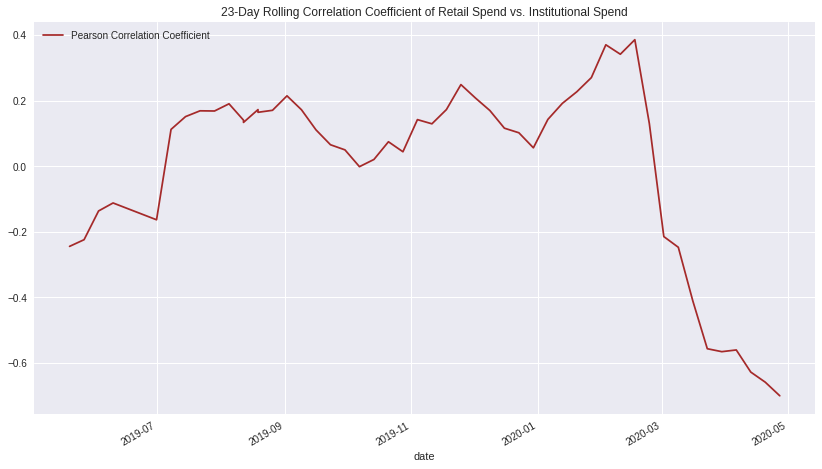

In [92]:
corr_trend.plot(figsize=(14, 8),
                color='brown',
                title='23-Day Rolling Correlation Coefficient of Retail Spend vs. Institutional Spend')
plt.legend(['Pearson Correlation Coefficient'])

## How does an increase in retail spending change the way the market moves?

The study of applying machine learning to sentiment analysis is not new. In the context of financial markets, many have tried to use various Natural Language Processing (NLP) techniques to process news headlines and social platforms to read the market sentiment. However, more often than not, trading strategies that use such models are inconsistent and unreliable.

The increase in the number of retail participants leads to an increase in reactionary trades. In financial literature, retail traders are often referred to as 'uninformed' traders. Therefore, they are more likely to *overreact* *(underreact)* to negative (positive) news and drive stock prices down (up). This is usually followed by some form of market correction.

I believe that the information gained from sentiment analysis cannot be completely useless. In the ARMA-GARCH models that I used, the goal was not to predict returns, but to predict conditional volatility. This proved to have limited success, but I learned that while it is difficult to predict the *sign* of returns, it is much easier to predict the *magnitude* of returns. This is crucial in risk management, and important in understanding how one's portfolio will be affected by an influx of speculative trades.

## What's next

I intend to first use PyTorch to develop a financial sentiment model. Then, I will devise a way to quantify this sentiment (e.g. sentiment score). I will also discuss other factors, such as news relevance (to a particular stock), and news flow (frequency of news publications). 

The aim is to use these factors as external regressors in the ARMA-GARCH models that I have defined previously. Based on my hypothesis, we should see a notable increase in the coefficients of the aforementioned factors around the end of February 2020, which suggests a that market volatility has a greater dependence on reactionary trading over that period.